# DE_IP_2024 — Task 4: Сегментация (Region Growing, критерии однородности, Watershed)


В этом ноутбуке решаем три пункта:

**1.** Подбор параметров **разрастания регионов** для выделения участка газона на SAR-снимке.  
**2.** Реализация альтернативного **критерия однородности** и сравнение результатов (abs-to-seed, mean-to-region, z-score).  
**3.** Сегментация **Watershed + Distance Transform** для **подсчёта пальм** на аэрофото.

Файлы изображений уже положены рядом: `sar_1.jpg`, `palm_1.JPG`, `oranges_1.jpg`.


In [1]:
# Параметры и пути к данным
SAR_PATH = "/mnt/data/sar_1.jpg"
PALM_PATH = "/mnt/data/palm_1.JPG"
ORANGE_PATH = "/mnt/data/oranges_1.jpg"

print("Paths OK:", SAR_PATH, PALM_PATH, ORANGE_PATH)

Paths OK: /mnt/data/sar_1.jpg /mnt/data/palm_1.JPG /mnt/data/oranges_1.jpg


## Импорт библиотек и вспомогательные функции

In [2]:

import cv2, numpy as np, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

def imshow_gray(img, title=None):
    plt.figure()
    if img.ndim == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

def overlay_mask(gray_or_bgr, mask, color=(0,255,0), alpha=0.5):
    if gray_or_bgr.ndim == 2:
        base = cv2.cvtColor(gray_or_bgr, cv2.COLOR_GRAY2BGR)
    else:
        base = gray_or_bgr.copy()
    overlay = base.copy()
    overlay[mask.astype(bool)] = color
    out = cv2.addWeighted(base, 1-alpha, overlay, alpha, 0)
    return out

def postprocess(mask, close_iter=2, open_iter=1, ksize=5):
    k = np.ones((ksize, ksize), np.uint8)
    m = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=close_iter)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k, iterations=open_iter)
    return m

def pick_smooth_seed(gray, percentile=70, win=9, subsample=500):
    """Автовыбор семени: яркие и однородные области (низкая локальная дисперсия)."""
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    th = np.percentile(blur, percentile)
    cand = np.argwhere(blur >= th)
    if len(cand) == 0:
        return (gray.shape[0]//2, gray.shape[1]//2)
    pad = win//2
    padded = cv2.copyMakeBorder(blur, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    best, best_std = None, 1e9
    step = max(1, len(cand)//subsample) if subsample else 1
    for y,x in cand[::step]:
        patch = padded[y:y+win, x:x+win]
        s = patch.std()
        if s < best_std:
            best_std, best = s, (y,x)
    return best

def region_growing(gray, seed, tol=10, max_iters=1_000_000, criterion='mean_abs'):
    """Простое 4-соседство. Критерии:
       - 'abs': |I - I_seed| <= tol
       - 'mean_abs': |I - mean(region)| <= tol (mean обновляется онлайн)
       - 'zscore': |I - mean|/std <= tol (tol в сигмах)
    """
    h, w = gray.shape
    visited = np.zeros((h,w), np.uint8)
    mask = np.zeros((h,w), np.uint8)
    q = [seed]
    visited[seed] = 1
    region_vals = [int(gray[seed])]
    mean = float(region_vals[0])
    var = 1e-6
    iters = 0

    while q and iters < max_iters:
        y, x = q.pop()
        val = int(gray[y,x])
        if criterion == 'abs':
            ok = abs(val - region_vals[0]) <= tol
        elif criterion == 'mean_abs':
            ok = abs(val - mean) <= tol
        else:  # zscore
            std = np.sqrt(max(var, 1e-6))
            ok = abs(val - mean) / std <= tol

        if ok:
            mask[y,x] = 1
            # Welford: онлайн-оценка среднего и дисперсии
            delta = val - mean
            mean += delta / (len(region_vals) + 1)
            var += delta * (val - mean)
            region_vals.append(val)
            for ny,nx in ((y-1,x),(y+1,x),(y,x-1),(y,x+1)):
                if 0<=ny<h and 0<=nx<w and not visited[ny,nx]:
                    visited[ny,nx] = 1
                    q.append((ny,nx))
        iters += 1

    if len(region_vals) > 1:
        var = var / (len(region_vals)-1)
    return mask.astype(np.uint8), mean, np.sqrt(var)

def mask_stats(mask):
    return dict(pixels=int(mask.sum()), area_frac=float(mask.mean()))


## 1–2. Разрастание регионов по SAR: подбор параметров и сравнение критериев

Размер: (300, 400)


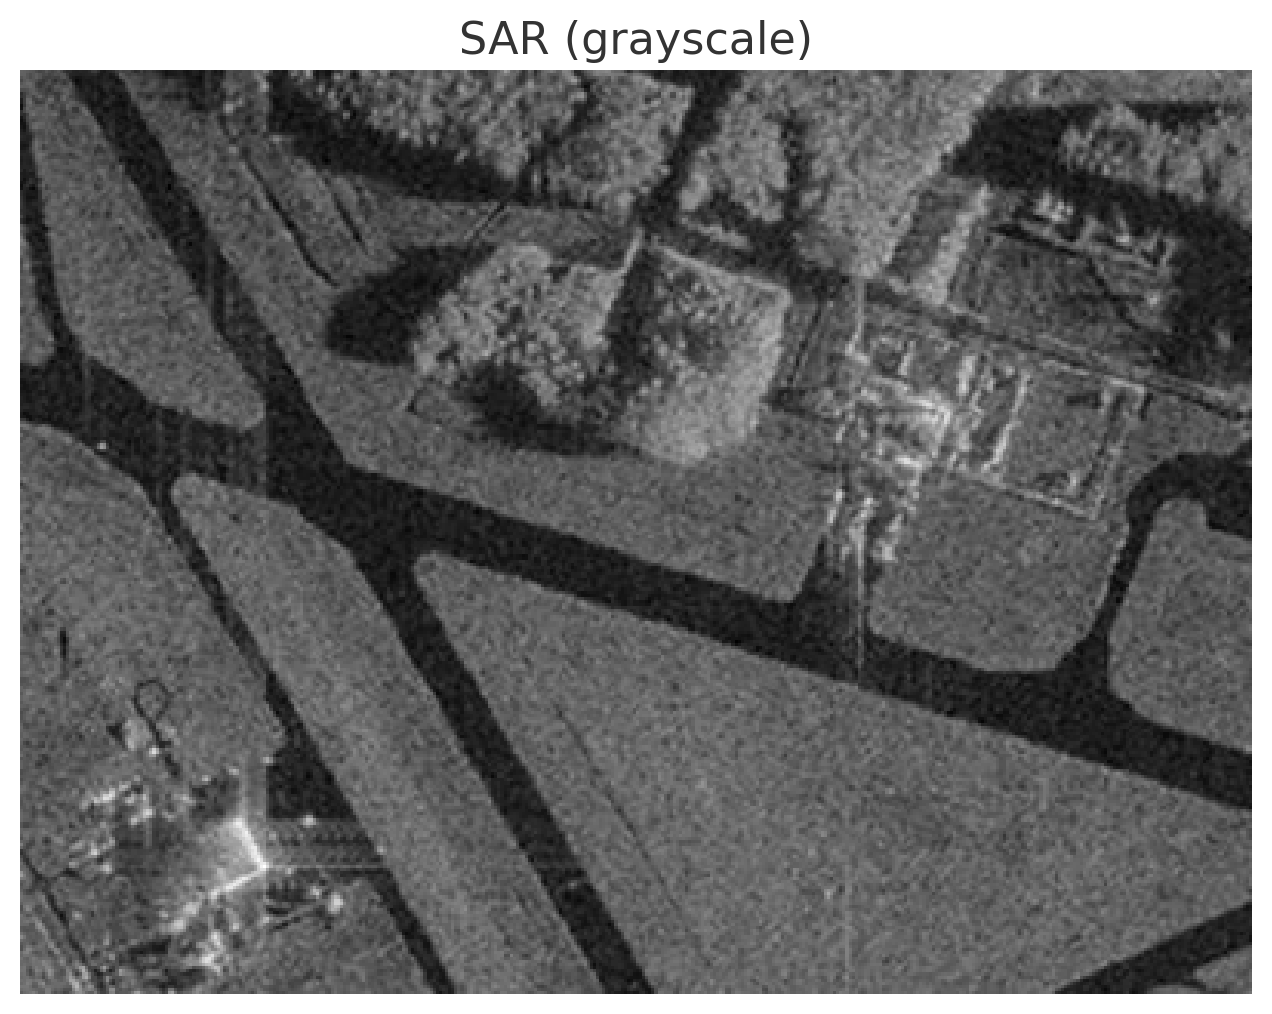

In [3]:

# Загружаем SAR
sar = cv2.imread(SAR_PATH, cv2.IMREAD_GRAYSCALE)
# Для стабильности можно немного уменьшить размер, если изображение очень большое
if max(sar.shape) > 1000:
    scale = 1000 / max(sar.shape)
    sar = cv2.resize(sar, (int(sar.shape[1]*scale), int(sar.shape[0]*scale)))
imshow_gray(sar, "SAR (grayscale)")
print("Размер:", sar.shape)


Seed (y, x): (297, 285)


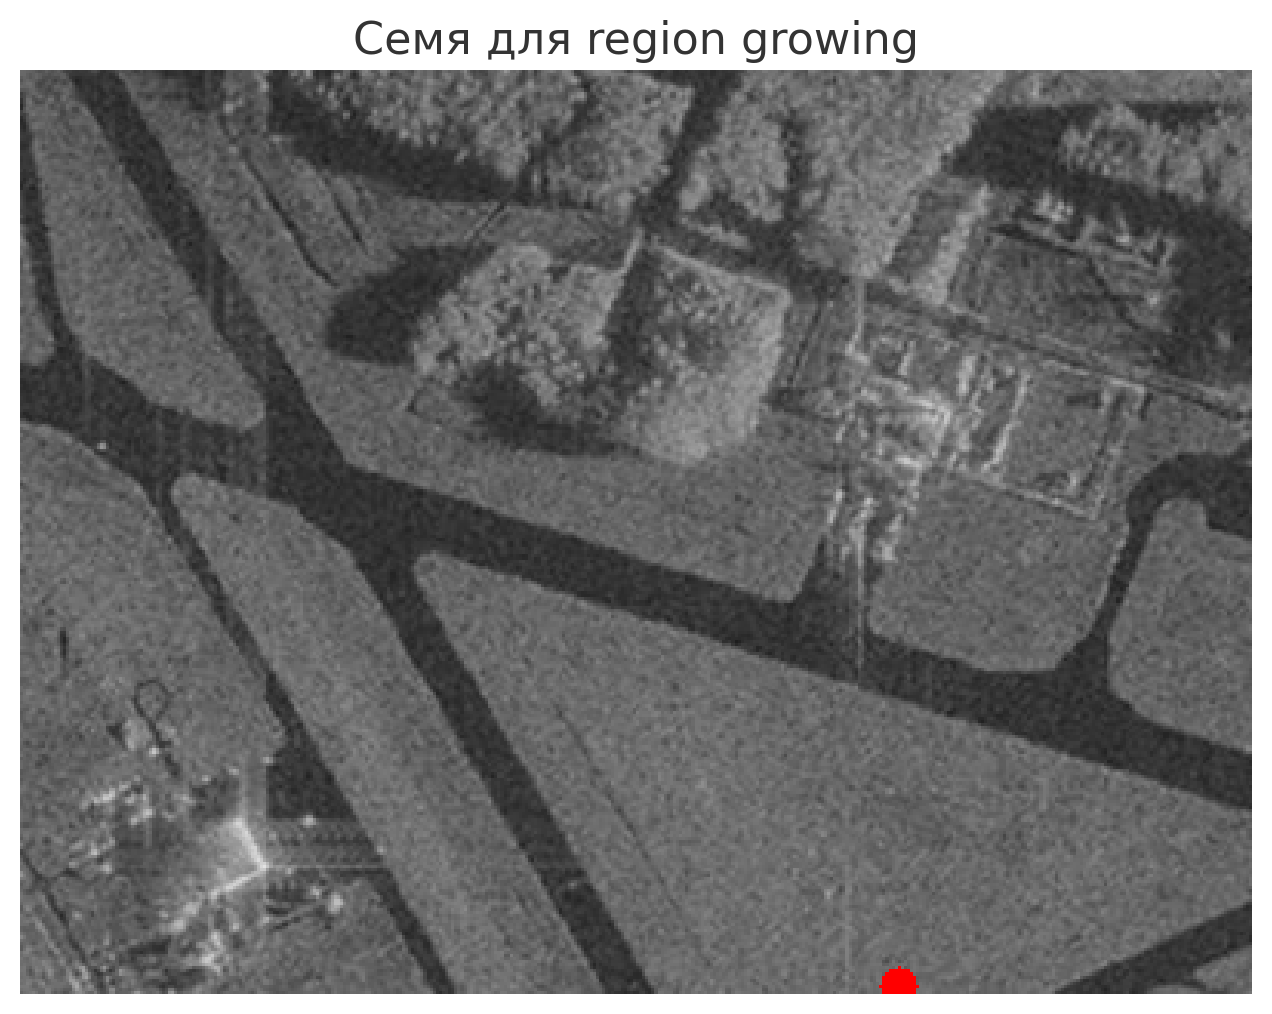

In [4]:

# Выбираем семя автоматически (яркая/однородная область) — газон на снимке чаще светлее асфальта
seed = pick_smooth_seed(sar, percentile=70, win=9, subsample=800)
print("Seed (y, x):", seed)
yy, xx = seed
sar_seed_vis = cv2.cvtColor(sar, cv2.COLOR_GRAY2BGR)
cv2.circle(sar_seed_vis, (int(xx), int(yy)), 6, (0,0,255), -1)
imshow_gray(sar_seed_vis, "Семя для region growing")


Статистика:
 abs: {'pixels': 21233, 'area_frac': 0.17694166666666666}
 mean_abs: {'pixels': 21150, 'area_frac': 0.17625}
 zscore: {'pixels': 0, 'area_frac': 0.0}


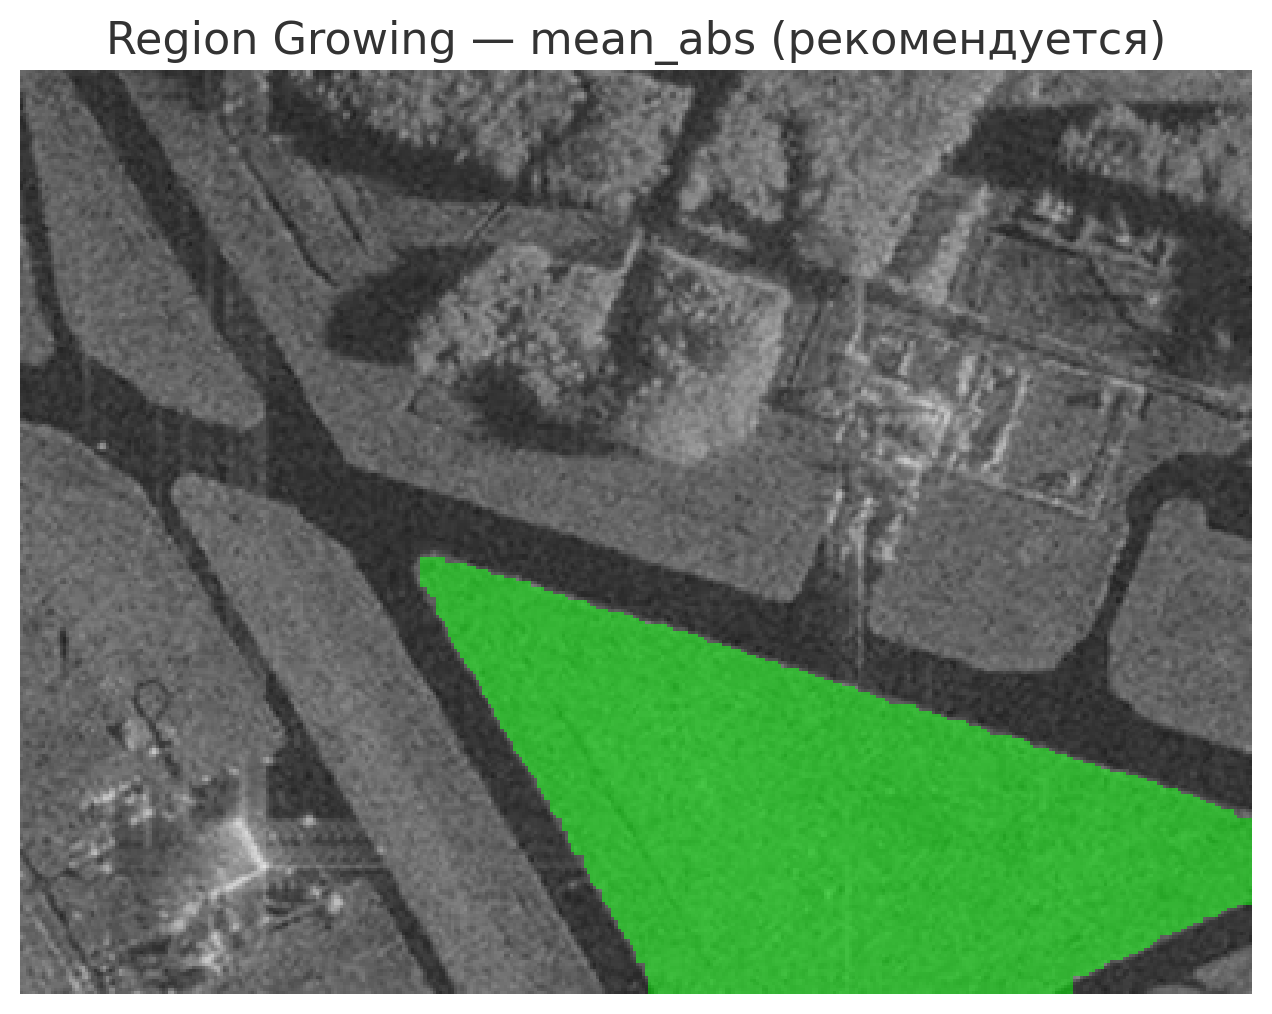

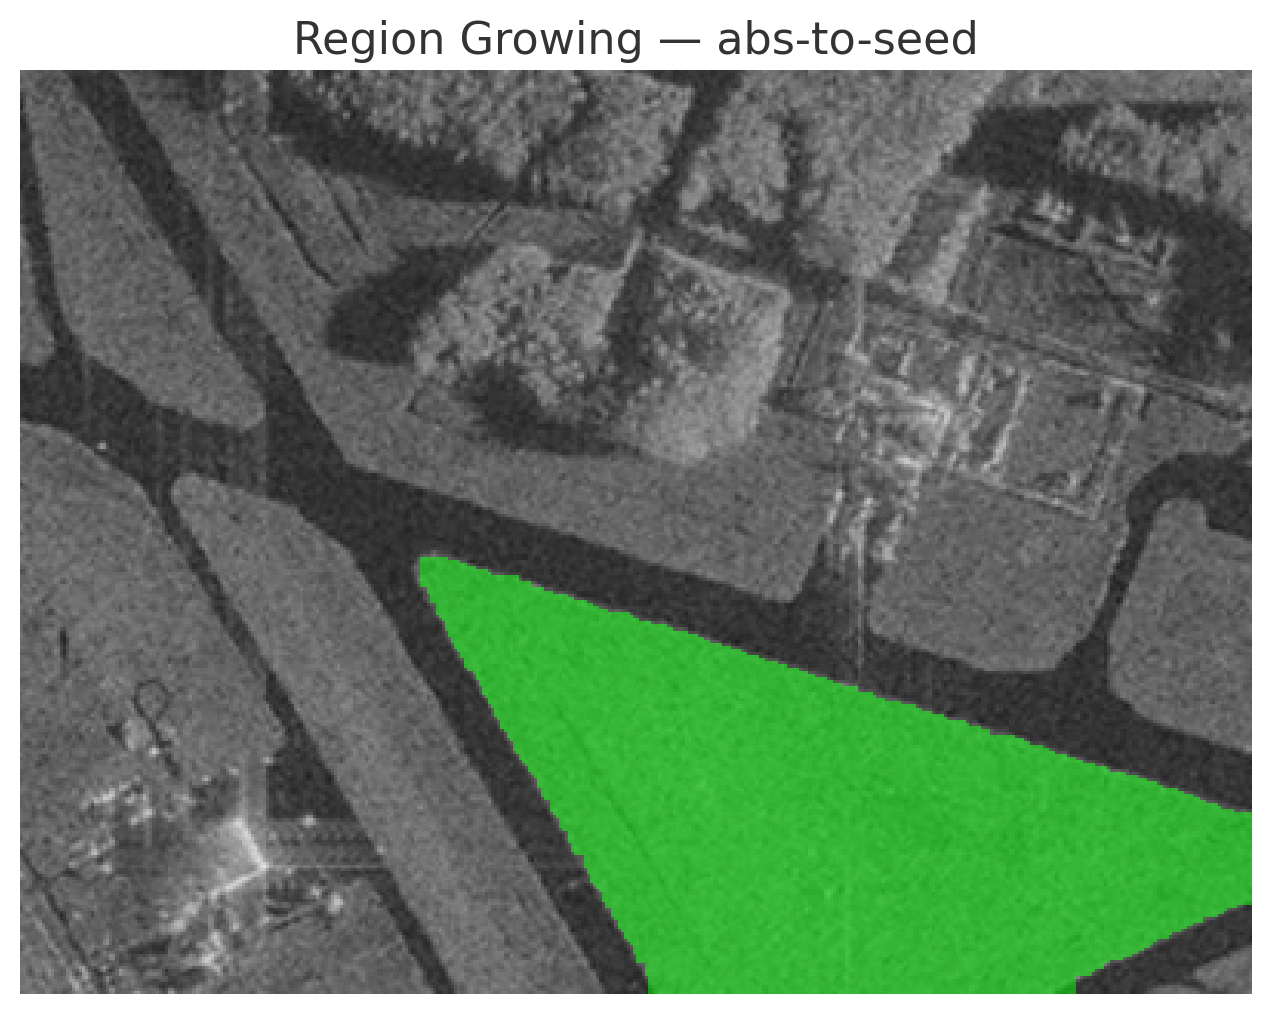

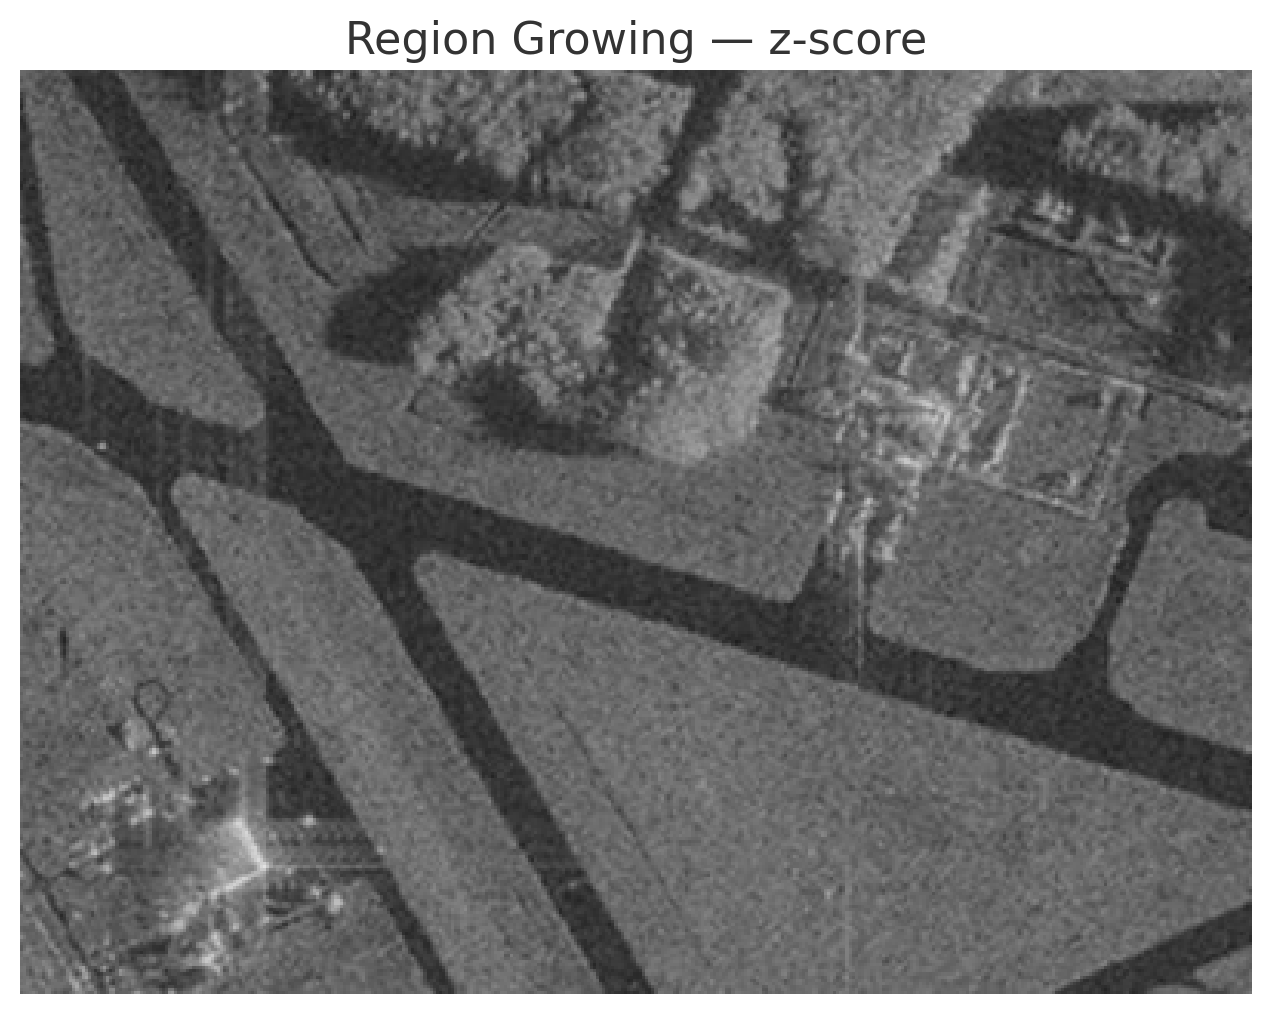

In [5]:

# Подбор параметров: попробуем три критерия с разумными толерансами
mask_abs, m_abs, s_abs = region_growing(sar, seed, tol=12, criterion='abs')
mask_mean, m_mean, s_mean = region_growing(sar, seed, tol=10, criterion='mean_abs')
mask_z, m_z, s_z = region_growing(sar, seed, tol=2.0, criterion='zscore')

# Постобработка и визуализация
m_abs_p = postprocess(mask_abs)
m_mean_p = postprocess(mask_mean)
m_z_p = postprocess(mask_z)

ov_abs = overlay_mask(sar, m_abs_p)
ov_mean = overlay_mask(sar, m_mean_p)
ov_z = overlay_mask(sar, m_z_p)

imshow_gray(ov_mean, "Region Growing — mean_abs (рекомендуется)")
imshow_gray(ov_abs,  "Region Growing — abs-to-seed")
imshow_gray(ov_z,    "Region Growing — z-score")
print("Статистика:")
print(" abs:", mask_stats(m_abs_p))
print(" mean_abs:", mask_stats(m_mean_p))
print(" zscore:", mask_stats(m_z_p))



**Комментарий по критериям**  
- `mean_abs` обычно устойчивее к локальному шуму и постепенно «подстраивается» под фактическую яркость газона.  
- `abs` зависит только от начального семени и может «перерастать»/«не дорастать» при одном и том же `tol`.  
- `zscore` нормирует на текущую дисперсию региона, хорошо подавляет шум, но чувствителен к выбору порога в «сигмах».


## 3. Watershed + Distance Transform для подсчёта пальм

Примерное число пальм: 231


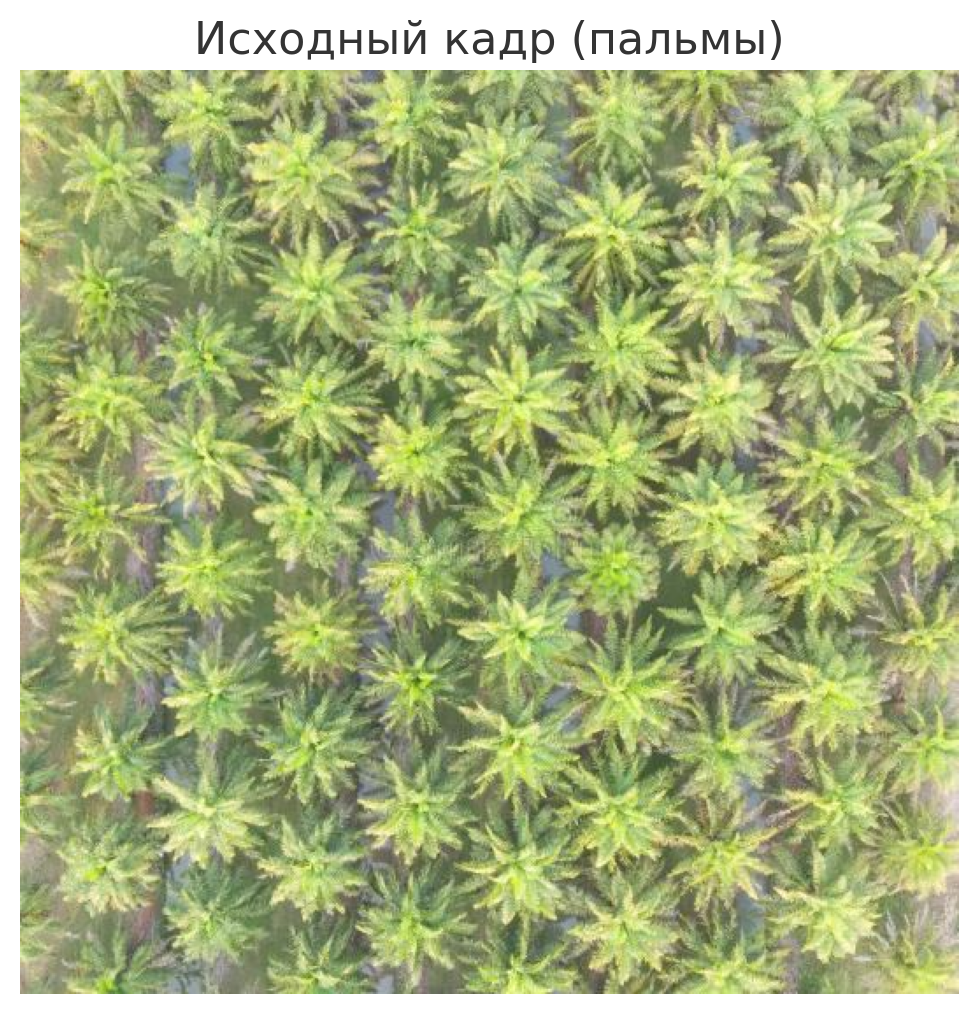

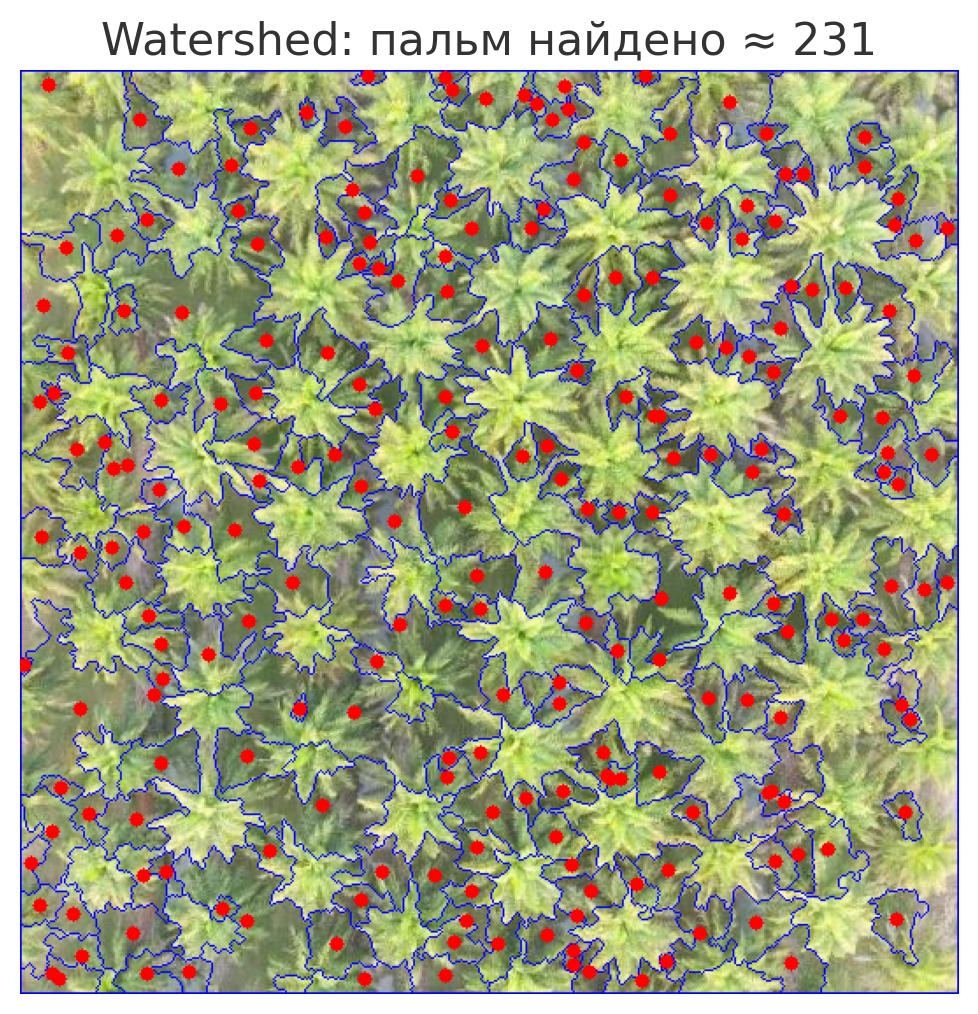

In [6]:

palm = cv2.imread(PALM_PATH)
imshow_gray(palm, "Исходный кадр (пальмы)")
gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Бинаризация: Оцу на инвертированном изображении => кроны как белые пятна
_, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Убираем шум
kernel = np.ones((3,3), np.uint8)
open_bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations=2)

# Distance transform и порог для пиков (маркеров)
dist = cv2.distanceTransform(open_bw, cv2.DIST_L2, 5)
thr = 0.35 * dist.max()    # этот коэффициент можно подстраивать (0.3–0.5)
_, sure_fg = cv2.threshold(dist, thr, 255, 0)
sure_fg = sure_fg.astype(np.uint8)

# Фон и неизвестная область
sure_bg = cv2.dilate(open_bw, np.ones((7,7), np.uint8), iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

# Маркеры компонент и watershed
num, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0
ws_img = palm.copy()
cv2.watershed(ws_img, markers)

labels = markers.copy()
labels[labels<=1] = 0
unique = np.unique(labels)
palm_count = int((unique>1).sum())

# Визуализация: границы и центры масс
vis = palm.copy()
vis[markers==-1] = (255,0,0)
centers = []
for label in unique:
    if label <= 1: 
        continue
    ys, xs = np.where(labels==label)
    if len(ys)==0: 
        continue
    yc, xc = int(np.mean(ys)), int(np.mean(xs))
    centers.append((xc,yc))
    cv2.circle(vis, (xc,yc), 4, (0,0,255), -1)

imshow_gray(vis, f"Watershed: пальм найдено ≈ {palm_count}")
print("Примерное число пальм:", palm_count)



### Примечания по точности подсчёта
- На результат сильно влияет **коэффициент порога пиков** distance-transform (`thr = 0.35 * max`).
- Для стабилизации можно фильтровать компоненты по **минимальной площади**, круглости, расстоянию между центрами и т.д.
- Если кадр сильно размытый/неоднородный по освещению, можно использовать CLAHE перед порогом.


## Дополнительно: бинаризация на oranges (пример для наработки идей)

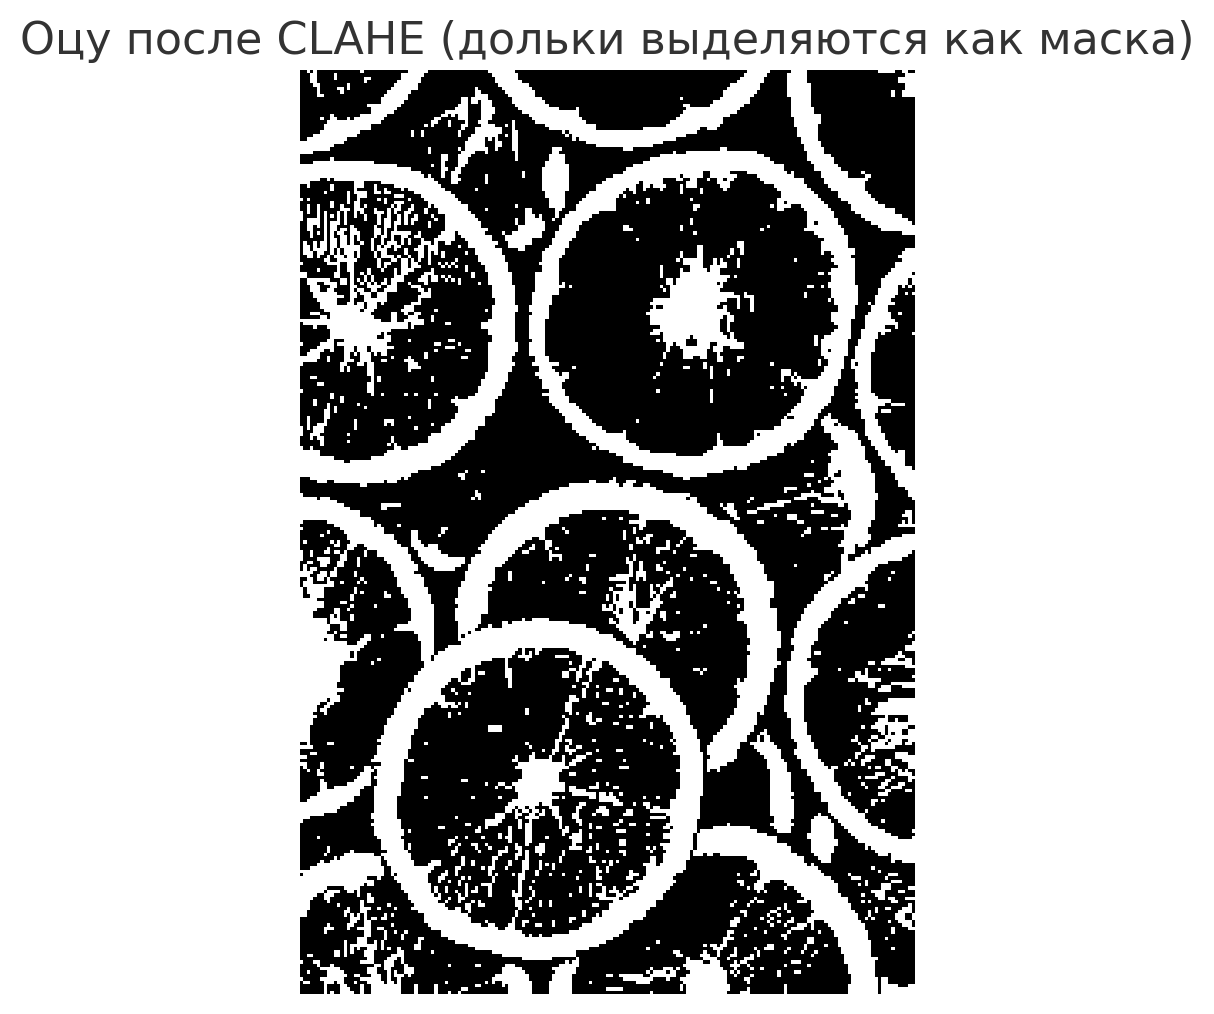

In [7]:

orange = cv2.imread(ORANGE_PATH)
gray_o = cv2.cvtColor(orange, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_o)
_, th_o = cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow_gray(th_o, "Оцу после CLAHE (дольки выделяются как маска)")

---
**Готово.** Меняйте параметры (`tol` у region growing, коэффициент `thr` у distance-transform), перезапускайте соответствующие ячейки и сравнивайте результат.